In [1]:
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import sparse
import scipy.io
import os
import anndata as ad # Anndata version must > 0.8
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')
from utils_unknown import *
import warnings
warnings.filterwarnings('ignore')

## Identifying tumor cell types (unknown cell types):  using the Healthy Adult Human Large Atlas (HHLA) to annotate BCC tumor sample data.

In [2]:
output_name = "BCC_samples"
out_dir = os.path.join("case_study", output_name)

reference_data_path = "data/Reference/HHLA_atlas.h5ad"
reference_data = load_reference_data(reference_data_path)
SU007_Total_Post = import_query_data(path = 'data/BCC_samples/SU007_Total_Post_vHealthyAdult',
                                    mtx_file = 'matrix.mtx.gz',
                                    cells_file = 'barcodes.tsv.gz',
                                    features_file = 'features.tsv.gz',
                                    variable_prefix = "SU007_Total_Post",
                                    celltype_col = "celltypes",
                                    add_metrics=False)
SU010_Total_Pre = import_query_data(path = 'data/BCC_samples/SU010_Total_Pre_vHealthyAdult',
                                    mtx_file = 'matrix.mtx.gz',
                                    cells_file = 'barcodes.tsv',
                                    features_file = 'features.tsv.gz',
                                    variable_prefix = "SU010_Total_Pre",
                                    celltype_col = "celltypes",
                                    add_metrics=False)

assert reference_data.var.shape[0] == SU010_Total_Pre.var.shape[0]
assert reference_data.var.shape[0] == SU007_Total_Post.var.shape[0]

In [3]:
reference_data.obs["CellType"] = reference_data.obs["celltypes"].values

concat_adata = sc.AnnData.concatenate(reference_data, SU010_Total_Pre)
concat_adata = sc.AnnData.concatenate(concat_adata, SU007_Total_Post)

Batch = ["reference"]*reference_data.shape[0] \
        + ["SU010_Total_Pre"]*SU010_Total_Pre.shape[0] \
        + ["SU007_Total_Post"] * SU007_Total_Post.shape[0] \
        
concat_adata.obs["Batch"] = Batch

In [4]:
peaks = concat_adata.var_names.values

chrom = [i.split(":")[0] for i in peaks]
start = [i.split(":")[1].split("-")[0] for i in peaks]
end = [i.split(":")[1].split("-")[1] for i in peaks]

concat_adata = make_anndata(
    adata = concat_adata, 
    chrom = chrom, 
    start = start, 
    end = end, 
    path = "preprocessed_data/BCC_1.h5ad"
)

Run CACNN

In [5]:
!python SANGO/CACNN/main.py -i preprocessed_data/BCC_1.h5ad \
                -g hg38 \
                -o output/BCC_1

Run GraphTransformer

In [6]:
!python SANGO/GraphTransformer/main.py --data_dir output/BCC_1/CACNN_output.h5ad \
                --train_name_list reference --test_name SU010_Total_Pre SU007_Total_Post \
                --save_path output \
                --save_name BCC_1 \
                --save_unknown --save_rare --no_smote --get_weight 

computing PCA
    with n_comps=50
    finished (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Leiden clustering
    finished: found 28 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)
computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
100%|███████████████████████████████████████| 1737/1737 [09:14<00:00,  3.13it/s]


**Note**:After the completion of GraphTransformer training, the representations of all cells are saved to the embedding.h5ad file, and the relationships between cells are saved to the weight.npy file. These files are stored in the folder named BCC_1.

We first create a dictionary of reference and query datasets

In [7]:
data_list = [SU007_Total_Post, SU010_Total_Pre]
print("total number of query cells: {}".format(np.sum([i.obs.shape[0] for i in data_list])))

total number of query cells: 1737


select features of datasets

In [8]:
select_features(reference_data)
for anndata in data_list:
    select_features(anndata)

datasets={}
datasets["Atlas"] = reference_data
for anndata in data_list:
    key = (anndata.obs["dataset"])[0]
    datasets[key] = anndata
datasets

{'Atlas': AnnData object with n_obs × n_vars = 100158 × 890130
     obs: 'celltypes', 'tissue', 'dataset', 'CellType'
     var: 'selected'
     uns: 'cell type_colors', 'major cell type_colors', 'spectral_eigenvalue', 'tissue_colors'
     obsm: 'X_umap',
 'SU007_Total_Post': AnnData object with n_obs × n_vars = 666 × 890130
     obs: 'celltypes', 'tissue', 'dataset'
     var: 'selected',
 'SU010_Total_Pre': AnnData object with n_obs × n_vars = 1071 × 890130
     obs: 'celltypes', 'tissue', 'dataset'
     var: 'selected'}

In [9]:
adata = sc.read_h5ad("output/BCC_1/embedding.h5ad")

datasets["Atlas"].obs["pred_GraphTransformer"] = adata[adata.obs["Batch"] == "reference"].obs["Pred"].values
datasets["SU010_Total_Pre"].obs["pred_GraphTransformer"] = adata[adata.obs["Batch"] == "SU010_Total_Pre"].obs["Pred"].values
datasets["SU007_Total_Post"].obs["pred_GraphTransformer"] = adata[adata.obs["Batch"] == "SU007_Total_Post"].obs["Pred"].values

datasets["Atlas"].obsm["X"] = adata[adata.obs["Batch"] == "reference"].X
datasets["SU010_Total_Pre"].obsm["X"] = adata[adata.obs["Batch"] == "SU010_Total_Pre"].X
datasets["SU007_Total_Post"].obsm["X"] = adata[adata.obs["Batch"] == "SU007_Total_Post"].X

integrated_adata = sc.AnnData.concatenate(datasets["Atlas"], datasets["SU010_Total_Pre"])
integrated_adata = sc.AnnData.concatenate(integrated_adata, datasets["SU007_Total_Post"])

In [10]:
# Plot UMAP using spectral embeddings
integrated_adata = get_umap(integrated_adata, out_dir, use_rep = "X", save = False)

In [11]:
reference = integrated_adata[integrated_adata.obs['dataset'] == "reference",:].copy()
reference.obs["celltypes"] =  curate_celltype_names(reference.obs["celltypes"], atlas = "HealthyAdult")

In [12]:
query = integrated_adata[integrated_adata.obs['dataset'] != "reference",:].copy()
query.obs_names = [j+"#"+i+"_"+j for i,j in zip(SU010_Total_Pre.obs_names.values, SU010_Total_Pre.obs["dataset"].values)] \
                    + [j+"#"+i+"_"+j for i,j in zip(SU007_Total_Post.obs_names.values, SU007_Total_Post.obs["dataset"].values)]

In [13]:
projection_allcells = pd.read_table("data/BCC_samples/BCC_study_metadata.csv", index_col = 0, sep = ",")
projection_allcells.index = [projection_allcells.loc[i,"Group"] + "#" + i for i in projection_allcells.index]
sample_names = ["SU010_Total_Pre", "SU007_Total_Post"]
projection = projection_allcells[projection_allcells["Group"].isin(sample_names)]
query.obs = pd.merge(query.obs, projection, left_index=True, right_index=True)

We utilized the attention weights between cells, saved in the 'weight.npy' file obtained from GraphTransformer, to compute the uncertainty score for each cell in the query data.

In [14]:
weight_path = "output/BCC_1/weight.npy"
get_uncertainty_score_step1(query, reference, weight_path)

AnnData object with n_obs × n_vars = 1737 × 890130
    obs: 'celltypes', 'tissue', 'dataset', 'CellType', 'pred_GraphTransformer', 'batch', 'UMAP_1', 'UMAP_2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name', 'Group_Barcode', 'true_label', 'uncertainty_score_step1', 'pred_y'
    var: 'selected-0-0', 'selected-1-0', 'selected-1'
    obsm: 'X', 'X_umap', 'kernel_distance', 'distance', 'indices', 'neighbors_labels'

We then project query cells into the same UMAP coordinates as original publication for better comparisons, and perform cluster-level assignment.

In [15]:
query.obsm["X_umap"] = np.array(query.obs[["UMAP_1", "UMAP_2"]])

uncertainty_threshold = 0.2
pred_y_unknown = np.array(query.obs["pred_y"].values)
uncertainty_score = np.array(query.obs["uncertainty_score_step1"].values)
pred_y_unknown[uncertainty_score > uncertainty_threshold] = "unknown"
query.obs["pred_y_unknown"] = pred_y_unknown

query_annotated = cluster_assign(query, use_rep = "X", cluster_col = "Clusters", UMAP=False)

<Figure size 7680x5760 with 0 Axes>

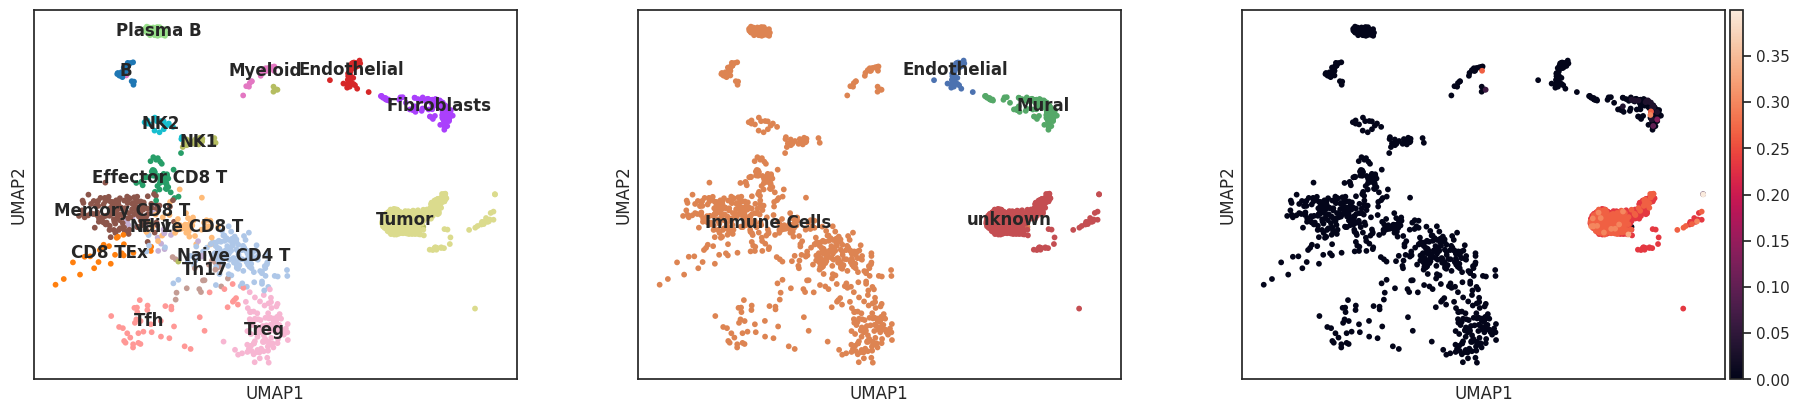

In [16]:
plt.figure(dpi=1200)
sc.pl.umap(query_annotated, 
           color = ['true_label', "cluster_annotation", 'uncertainty_score_step1'], 
           title=["", "", ""], 
           legend_loc = "on data", 
)

<Figure size 7680x5760 with 0 Axes>

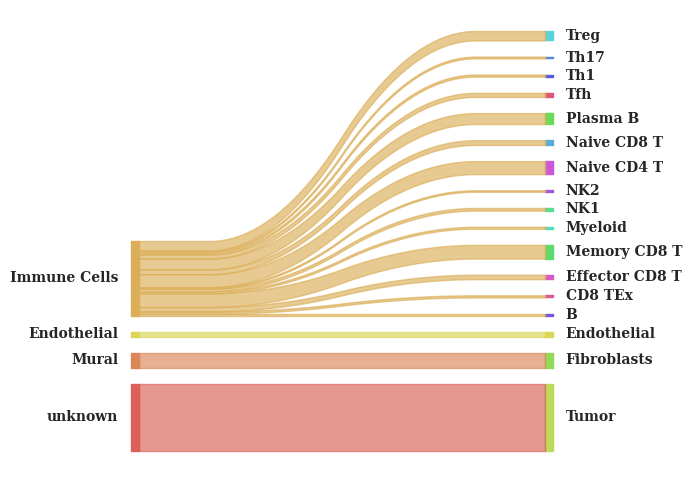

In [17]:
pred_col = 'cluster_annotation'
true_col = 'true_label'

plt.rcParams['font.weight'] = "heavy"
plt.figure(dpi=1200)

sankey(
    query_annotated.obs[pred_col], query_annotated.obs[true_col], aspect=10,
    fontsize=10, leftLabels=["unknown", "Mural", "Endothelial", "Immune Cells"],
    rightLabels=['Tumor', 'Fibroblasts', 'Endothelial',
                 'B', 'CD8 TEx', 'Effector CD8 T',
                 'Memory CD8 T', 'Myeloid', 'NK1', 'NK2', 'Naive CD4 T',
                 'Naive CD8 T', 'Plasma B', 'Tfh', 'Th1', 'Th17', 'Treg']
    )

In [18]:
immune_cells = pd.DataFrame(query_annotated[query_annotated.obs["cluster_annotation"] == "Immune Cells"].obs.index)
print(immune_cells.head())

                                                   0
0  SU010_Total_Pre#SU010_Total_Pre#TACTGCCAGTTGAA...
1  SU010_Total_Pre#SU010_Total_Pre#AGCGATTAGAACTA...
2  SU010_Total_Pre#SU010_Total_Pre#GCCCGAAAGGCACC...
3  SU010_Total_Pre#SU010_Total_Pre#TCTCAGCCAGTTGG...
4  SU010_Total_Pre#SU010_Total_Pre#TATGTGGGTGAGGG...


## Identifying subtypes:  using BCC_TIL_atlas to annotate BCC immune subtype cells

In [19]:
reference_data_path = "data/Reference/BCC_TIL_atlas.h5ad"
reference_data = load_reference_data(reference_data_path)
SU007_Total_Post = import_query_data(path = 'data/BCC_samples/SU007_Total_Post_vBCC',
                                    mtx_file = 'matrix.mtx.gz',
                                    cells_file = 'barcodes.tsv.gz',
                                    features_file = 'features.tsv.gz',
                                    variable_prefix = "SU007_Total_Post",
                                    celltype_col = "celltypes",
                                    add_metrics=False)
SU010_Total_Pre = import_query_data(path = 'data/BCC_samples/SU010_Total_Pre_vBCC',
                                    mtx_file = 'matrix.mtx.gz',
                                    cells_file = 'barcodes.tsv',
                                    features_file = 'features.tsv.gz',
                                    variable_prefix = "SU010_Total_Pre",
                                    celltype_col = "celltypes",
                                    add_metrics=False)

In [20]:
data_list = [SU007_Total_Post, SU010_Total_Pre]
print("Total number of query cells: {}".format(np.sum([i.obs.shape[0] for i in data_list])))
data_list

Total number of query cells: 1737


[View of AnnData object with n_obs × n_vars = 666 × 344492
     obs: 'celltypes', 'tissue', 'dataset',
 View of AnnData object with n_obs × n_vars = 1071 × 344492
     obs: 'celltypes', 'tissue', 'dataset']

In [21]:
immune_cells.index = immune_cells[0]
immune_cells.index = [i.split("_SU")[0] for i in immune_cells.index]
immune_cells.index = [i.split("#")[1] + "#" + i.split("#")[2] for i in immune_cells.index]
immune_cells.head()

,0
SU010_Total_Pre#TACTGCCAGTTGAATG-1,SU010_Total_Pre#SU010_Total_Pre#TACTGCCAGTTGAA...
SU010_Total_Pre#AGCGATTAGAACTAAC-1,SU010_Total_Pre#SU010_Total_Pre#AGCGATTAGAACTA...
SU010_Total_Pre#GCCCGAAAGGCACCTC-1,SU010_Total_Pre#SU010_Total_Pre#GCCCGAAAGGCACC...
SU010_Total_Pre#TCTCAGCCAGTTGGAG-1,SU010_Total_Pre#SU010_Total_Pre#TCTCAGCCAGTTGG...
SU010_Total_Pre#TATGTGGGTGAGGGTT-1,SU010_Total_Pre#SU010_Total_Pre#TATGTGGGTGAGGG...


In [22]:
data_list_use = data_list.copy()
for i in range(len(data_list_use)):
    print(data_list_use[i].obs["dataset"][0])
    data_list_use[i] = data_list_use[i][data_list_use[i].obs.index.isin(immune_cells.index)]
    print(data_list_use[i])

print("Total immune cells: {}".format(np.sum([i.obs.shape[0] for i in data_list_use])))

SU007_Total_Post
View of AnnData object with n_obs × n_vars = 618 × 344492
    obs: 'celltypes', 'tissue', 'dataset'
SU010_Total_Pre
View of AnnData object with n_obs × n_vars = 188 × 344492
    obs: 'celltypes', 'tissue', 'dataset'
Total immune cells: 806


In [23]:
reference_data.obs["CellType"] = reference_data.obs["celltypes"].values

In [24]:
concat_adata = sc.AnnData.concatenate(reference_data, data_list_use[1])
concat_adata = sc.AnnData.concatenate(concat_adata, data_list_use[0])

Batch = ["reference"]*reference_data.shape[0] \
        + ["SU010_Total_Pre"]*data_list_use[1].shape[0] \
        + ["SU007_Total_Post"] * data_list_use[0].shape[0] \
        
concat_adata.obs["Batch"] = Batch

In [25]:
peaks = concat_adata.var_names.values

chrom = [i.split(":")[0] for i in peaks]
start = [i.split(":")[1].split("-")[0] for i in peaks]
end = [i.split(":")[1].split("-")[1] for i in peaks]

concat_adata = make_anndata(
    adata = concat_adata, 
    chrom = chrom, 
    start = start, 
    end = end, 
    path = "preprocessed_data/BCC_2_Cluster.h5ad"
)

Run CACNN

In [26]:
!python SANGO/CACNN/main.py -i preprocessed_data/BCC_2_Cluster.h5ad \
                -g hg38 \
                -o output/BCC_2

Run GraphTransformer

In [27]:
!python SANGO/GraphTransformer/main.py --data_dir output/BCC_2/CACNN_output.h5ad \
                --train_name_list reference --test_name SU010_Total_Pre SU007_Total_Post \
                --save_path output \
                --save_name BCC_2 \
                --save_unknown --save_rare --no_smote 

computing PCA
    with n_comps=50
    finished (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
100%|█████████████████████████████████████████| 300/300 [02:43<00:00,  1.83it/s]


In [28]:
for anndata in data_list_use:
    select_features(anndata)
select_features(reference_data)

datasets={}
datasets["Atlas"] = reference_data
for anndata in data_list_use:
    key = (anndata.obs["dataset"])[0]
    datasets[key] = anndata
datasets

{'Atlas': AnnData object with n_obs × n_vars = 22008 × 344492
     obs: 'celltypes', 'tissue', 'dataset', 'CellType'
     var: 'selected'
     uns: 'Group_colors', 'celltypes_colors', 'spectral_eigenvalue', 'true_label_colors'
     obsm: 'X_spectral', 'X_umap',
 'SU007_Total_Post': AnnData object with n_obs × n_vars = 618 × 344492
     obs: 'celltypes', 'tissue', 'dataset'
     var: 'selected',
 'SU010_Total_Pre': AnnData object with n_obs × n_vars = 188 × 344492
     obs: 'celltypes', 'tissue', 'dataset'
     var: 'selected'}

In [29]:
adata = sc.read_h5ad("output/BCC_2/embedding.h5ad")

datasets["Atlas"].obs["pred_GraphTransformer"] = adata[adata.obs["Batch"] == "reference"].obs["Pred"].values
datasets["SU010_Total_Pre"].obs["pred_GraphTransformer"] = adata[adata.obs["Batch"] == "SU010_Total_Pre"].obs["Pred"].values
datasets["SU007_Total_Post"].obs["pred_GraphTransformer"] = adata[adata.obs["Batch"] == "SU007_Total_Post"].obs["Pred"].values

datasets["Atlas"].obsm["X"] = adata[adata.obs["Batch"] == "reference"].X
datasets["SU010_Total_Pre"].obsm["X"] = adata[adata.obs["Batch"] == "SU010_Total_Pre"].X
datasets["SU007_Total_Post"].obsm["X"] = adata[adata.obs["Batch"] == "SU007_Total_Post"].X

integrated_adata = sc.AnnData.concatenate(datasets["Atlas"], datasets["SU010_Total_Pre"])
integrated_adata = sc.AnnData.concatenate(integrated_adata, datasets["SU007_Total_Post"])
print(integrated_adata)

AnnData object with n_obs × n_vars = 22814 × 344492
    obs: 'celltypes', 'tissue', 'dataset', 'CellType', 'pred_GraphTransformer', 'batch'
    var: 'selected-0-0', 'selected-1-0', 'selected-1'
    obsm: 'X'


In [30]:
output_name = "BCC_samples"
out_dir = os.path.join("case_study", output_name)

#Plot UMAP using spectral embeddings
integrated_adata = get_umap(integrated_adata, out_dir, use_rep = "X", save = False)

In [31]:
query = integrated_adata[integrated_adata.obs['dataset'] != "reference",:].copy()
query.obs_names = [j+"#"+i.split("-")[0] + "-1" + "_" + j for i,j in zip(query.obs_names.values, query.obs["dataset"].values)]

In [32]:
projection_allcells = pd.read_table("data/BCC_samples/BCC_study_metadata.csv", index_col = 0, sep = ",")
projection_allcells.index = [projection_allcells.loc[i,"Group"] + "#" + i for i in projection_allcells.index]
projection_allcells["true_label"] = [i.strip() for i in projection_allcells["true_label"]]
sample_names = ["SU010_Total_Pre", "SU007_Total_Post"]
projection = projection_allcells[projection_allcells["Group"].isin(sample_names)]
query.obs = pd.merge(query.obs, projection, left_index=True, right_index=True)
query.obs

,celltypes,tissue,dataset,CellType,pred_GraphTransformer,batch,UMAP_1,UMAP_2,Clusters,Group,depth,FRIP,Barcodes,Internal_Name,Group_Barcode,true_label
SU010_Total_Pre#SU010_Total_Pre#TACTGCCAGTTGAATG-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,NaN,Plasma B,0,-3.741690,16.458853,Cluster13,SU010_Total_Pre,22180,0.629306,TACTGCCAGTTGAATG-1,SU010_Total_Pre_824,SU010_Total_Pre#TACTGCCAGTTGAATG-1,Plasma B
SU010_Total_Pre#SU010_Total_Pre#AGCGATTAGAACTAAC-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,NaN,Memory CD8 T,0,-5.042978,3.294526,Cluster7,SU010_Total_Pre,26713,0.645416,AGCGATTAGAACTAAC-1,SU010_Total_Pre_4,SU010_Total_Pre#AGCGATTAGAACTAAC-1,Memory CD8 T
SU010_Total_Pre#SU010_Total_Pre#GCCCGAAAGGCACCTC-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,NaN,Plasma B,0,-3.297045,16.337175,Cluster13,SU010_Total_Pre,12510,0.385012,GCCCGAAAGGCACCTC-1,SU010_Total_Pre_843,SU010_Total_Pre#GCCCGAAAGGCACCTC-1,Plasma B
SU010_Total_Pre#SU010_Total_Pre#TCTCAGCCAGTTGGAG-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,NaN,Memory CD8 T,0,-5.287196,1.745298,Cluster7,SU010_Total_Pre,26865,0.630430,TCTCAGCCAGTTGGAG-1,SU010_Total_Pre_77,SU010_Total_Pre#TCTCAGCCAGTTGGAG-1,Memory CD8 T
SU010_Total_Pre#SU010_Total_Pre#TATGTGGGTGAGGGTT-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,NaN,Th1,0,-4.390906,1.357552,Cluster10,SU010_Total_Pre,14660,0.279775,TATGTGGGTGAGGGTT-1,SU010_Total_Pre_203,SU010_Total_Pre#TATGTGGGTGAGGGTT-1,NK1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SU007_Total_Post#SU007_Total_Post#GCACCTTCACTCGGAC-1_SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,NaN,Naive CD4 T,1,0.582895,0.034329,Cluster1,SU007_Total_Post,7646,0.669173,GCACCTTCACTCGGAC-1,SU007_Total_Post_657,SU007_Total_Post#GCACCTTCACTCGGAC-1,Naive CD4 T
SU007_Total_Post#SU007_Total_Post#GCCTACTCATTCACGA-1_SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,NaN,Naive CD4 T,1,-2.006158,1.166633,Cluster5,SU007_Total_Post,2480,0.653629,GCCTACTCATTCACGA-1,SU007_Total_Post_628,SU007_Total_Post#GCCTACTCATTCACGA-1,Naive CD8 T
SU007_Total_Post#SU007_Total_Post#AATGGAACAAGGTCGA-1_SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,NaN,Memory CD8 T,1,-5.390166,1.350978,Cluster7,SU007_Total_Post,4456,0.638241,AATGGAACAAGGTCGA-1,SU007_Total_Post_660,SU007_Total_Post#AATGGAACAAGGTCGA-1,Memory CD8 T
SU007_Total_Post#SU007_Total_Post#TACCTATAGTACGACG-1_SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,NaN,Memory CD8 T,1,-4.832208,3.385367,Cluster7,SU007_Total_Post,3617,0.686342,TACCTATAGTACGACG-1,SU007_Total_Post_661,SU007_Total_Post#TACCTATAGTACGACG-1,Memory CD8 T


In [33]:
query.obsm["X_umap"] = np.array(query.obs[["UMAP_1", "UMAP_2"]])
query.obs["pred_y_unknown"] = np.array(query.obs["pred_GraphTransformer"].values)
query_annotated = cluster_assign(query, use_rep = "X", cluster_col = "Clusters", UMAP=False)

<Figure size 7680x5760 with 0 Axes>

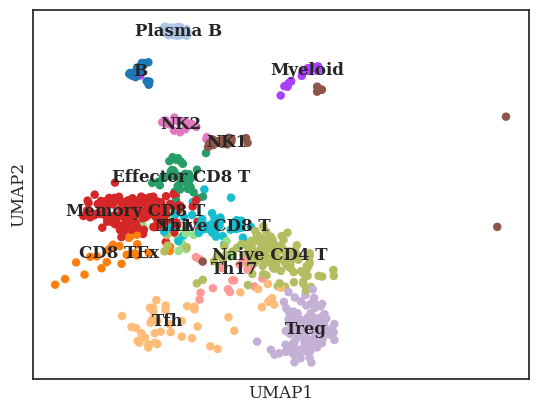

In [34]:
plt.figure(dpi=1200)
sc.pl.umap(query_annotated, color = "cluster_annotation", title="", legend_loc = "on data")

<Figure size 7680x5760 with 0 Axes>

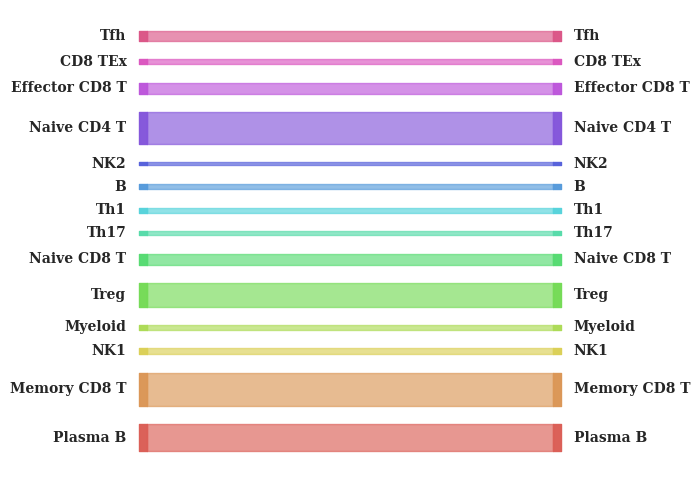

In [35]:
pred_col = 'cluster_annotation'
true_col = 'true_label'

plt.rcParams['font.weight'] = "heavy"
plt.figure(dpi=1200)
sankey(
    query_annotated.obs[pred_col], query_annotated.obs[true_col], aspect=10,
    fontsize=10
    )